In [1]:
#timm - Library has all the pre-trained model
#nbdev has the documentation library
#pynvml - NVIDIA library

!pip install --upgrade fastai fastcore timm kaggle pynvml nbdev -qq

     |████████████████████████████████| 549 kB 4.3 MB/s 
     |████████████████████████████████| 46 kB 3.2 MB/s 
     |████████████████████████████████| 64 kB 1.3 MB/s 
     |████████████████████████████████| 182 kB 89.4 MB/s 
     |████████████████████████████████| 78 kB 4.0 MB/s 
     |████████████████████████████████| 58 kB 3.7 MB/s 
     |████████████████████████████████| 1.6 MB 92.2 MB/s 


In [2]:
from pathlib import Path
base_folder = Path('/content/drive/MyDrive/Deep_Learning_UTD')

In [3]:
data_folder = base_folder/'Dataset'/'paddy_disease_classification'
model_folder = base_folder/'Model'/'paddy_disease_classification'
archive_folder = base_folder/'archive'
kaggle_api = base_folder/'.kaggle' #Hidden folder

In [4]:
data_folder.mkdir(exist_ok=True, parents=True) #Folder for storing data
model_folder.mkdir(exist_ok=True, parents=True) #Folder for storing pre-trained models
archive_folder.mkdir(exist_ok=True, parents=True) #Folder for storing zip files
kaggle_api.mkdir(exist_ok=True, parents=True) #Folder for the kaggle API

In [5]:
kaggle_api

PosixPath('/content/drive/MyDrive/Deep_Learning_UTD/.kaggle')

In [6]:
#Save the kaggle API (.json) from your account to the .kaggle folder

!ls -la /content/drive/MyDrive/Deep_Learning_UTD/.kaggle

total 1
-rw------- 1 root root 66 Nov 14 22:32 kaggle.json


In [7]:
#Tell the notebook that the kaggle.json file's saved location

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Deep_Learning_UTD/.kaggle'

In [8]:
! chmod 777 '/content/drive/MyDrive/Deep_Learning_UTD/.kaggle'

In [9]:
!ls -la /content/drive/MyDrive/Deep_Learning_UTD/.kaggle

total 1
-rw------- 1 root root 66 Nov 14 22:32 kaggle.json


In [10]:
from fastai.vision.all import *
from kaggle import api
from fastcore.parallel import *
import timm

In [11]:
#Tell kaggle where to download dataset - to archive folder
!kaggle competitions download -c paddy-disease-classification -p {archive_folder}

paddy-disease-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!ls -la {archive_folder}

total 1067753
-rw------- 1 root root 1093378623 Nov 14 22:51 paddy-disease-classification.zip


In [13]:
data_file = archive_folder/'paddy-disease-classification.zip'

In [14]:
# !unzip -q {data_file} -d {data_folder}

In [15]:
Path.BASE_PATH = data_folder

In [16]:
#List the contents of the unzipped data_folder - Contains 4 files

data_folder.ls()

(#4) [Path('sample_submission.csv'),Path('train.csv'),Path('test_images'),Path('train_images')]

In [17]:
#List out all the files under the train images - Contains 10 folder

(data_folder/'train_images').ls()

(#10) [Path('train_images/bacterial_leaf_blight'),Path('train_images/bacterial_leaf_streak'),Path('train_images/bacterial_panicle_blight'),Path('train_images/blast'),Path('train_images/brown_spot'),Path('train_images/dead_heart'),Path('train_images/downy_mildew'),Path('train_images/hispa'),Path('train_images/normal'),Path('train_images/tungro')]

In [18]:
#List of all the files under the each_folder of the train_images - Contains 479 files

(data_folder/'train_images/bacterial_leaf_blight').ls()

(#479) [Path('train_images/bacterial_leaf_blight/101394.jpg'),Path('train_images/bacterial_leaf_blight/104494.jpg'),Path('train_images/bacterial_leaf_blight/100382.jpg'),Path('train_images/bacterial_leaf_blight/104017.jpg'),Path('train_images/bacterial_leaf_blight/100967.jpg'),Path('train_images/bacterial_leaf_blight/103344.jpg'),Path('train_images/bacterial_leaf_blight/104430.jpg'),Path('train_images/bacterial_leaf_blight/105521.jpg'),Path('train_images/bacterial_leaf_blight/103313.jpg'),Path('train_images/bacterial_leaf_blight/102117.jpg')...]

In [19]:
train_path = data_folder/'train_images'
test_path = data_folder/'test_images'

In [20]:
#File names stored in a list

train_files = get_image_files(train_path)
test_files = get_image_files(test_path)

In [21]:
train_files

(#10407) [Path('train_images/bacterial_leaf_blight/101394.jpg'),Path('train_images/bacterial_leaf_blight/104494.jpg'),Path('train_images/bacterial_leaf_blight/100382.jpg'),Path('train_images/bacterial_leaf_blight/104017.jpg'),Path('train_images/bacterial_leaf_blight/100967.jpg'),Path('train_images/bacterial_leaf_blight/103344.jpg'),Path('train_images/bacterial_leaf_blight/104430.jpg'),Path('train_images/bacterial_leaf_blight/105521.jpg'),Path('train_images/bacterial_leaf_blight/103313.jpg'),Path('train_images/bacterial_leaf_blight/102117.jpg')...]

In [22]:
#Get the parent labels of the train files

train_labels = [parent_label(o) for o in train_files]

In [23]:
train_labels[:5]

['bacterial_leaf_blight',
 'bacterial_leaf_blight',
 'bacterial_leaf_blight',
 'bacterial_leaf_blight',
 'bacterial_leaf_blight']

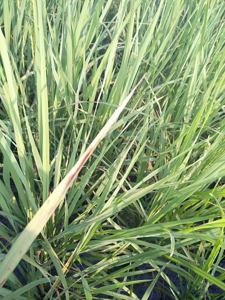

In [24]:
#Display the images

img = PILImage.create(train_files[0])
img.to_thumb(h = 300)

In [25]:
img.size

(480, 640)

In [26]:
#Check if all the files have the same size or not

def get_image_size(file):
  return PILImage.create(file).size

In [27]:
# train_sizes = parallel(get_image_size, train_files)

In [28]:
df_kaggle_train = pd.read_csv(data_folder/'train.csv')
df_kaggle_train.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [29]:
#DataBlock helps in creating dataloaders. You have to give in few details as below

dblock = DataBlock(blocks = [ImageBlock,CategoryBlock],
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(seed = 42),
                   item_tfms=Resize(size = (640,480), method = 'squish'),
                   batch_tfms = aug_transforms(size = (320,240), min_scale = 1))

In [30]:
doc(DataBlock)

In [31]:
dblock.summary(data_folder/'train_images')

Setting-up type transforms pipelines
Found 10407 items
2 datasets of sizes 8326,2081
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/MyDrive/Deep_Learning_UTD/Dataset/paddy_disease_classification/train_images/downy_mildew/107322.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=480x640
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/MyDrive/Deep_Learning_UTD/Dataset/paddy_disease_classification/train_images/downy_mildew/107322.jpg
    applying parent_label gives
      downy_mildew
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=480x640, TensorCategory(6))


Found 10407 items
2 datasets of sizes 8326,2081
Setting up Pipeline: PI

In [32]:
#Create Dataloader from the Datablock

dls = dblock.dataloaders(data_folder/'train_images')

In [33]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

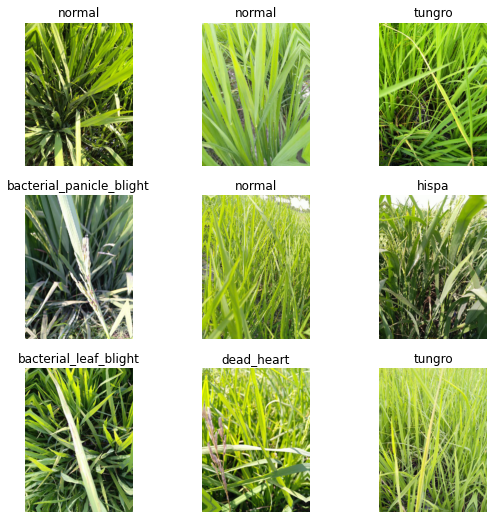

In [34]:
dls.train.show_batch()

In [35]:
dls.device

device(type='cuda', index=0)

In [36]:
#Create Dataloader - dls1

dls1 = dblock.dataloaders(data_folder/'train_images', bs = 64)

In [37]:
#Train the model using a pre-trained model
learn = vision_learner(dls1, 'resnet26d', metrics = error_rate, path = model_folder).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


In [38]:
learn.fine_tune(3,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.594763,1.112090,0.356079,03:43


epoch,train_loss,valid_loss,error_rate,time
0,0.938511,0.646704,0.205670,00:26
1,0.577039,0.348708,0.111004,00:26
2,0.362170,0.269658,0.078808,00:25


In [39]:
sample_submission = pd.read_csv(data_folder/'sample_submission.csv')

In [52]:
test_files = get_image_files(data_folder/'test_images').sorted()

In [53]:
test_dl = learn.dls.test_dl(test_files)

In [54]:
preds, _ = learn.tta(dl = test_dl)

In [55]:
preds.shape

torch.Size([3469, 10])

In [56]:
idxs = preds.argmax(dim = 1)

In [57]:
idxs

TensorBase([7, 8, 3,  ..., 8, 1, 5])

In [58]:
vocab = np.array(learn.dls.vocab)
vocab

array(['bacterial_leaf_blight', 'bacterial_leaf_streak',
       'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
       'downy_mildew', 'hispa', 'normal', 'tungro'], dtype='<U24')

In [59]:
results = pd.Series(vocab[idxs], name = 'idxs')
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [60]:
sample_submission['label'] = results

In [61]:
sample_submission

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [62]:
sample_submission.to_csv(model_folder/'first_sub.csv', index = False)

In [63]:
comp = 'paddy-disease-classification'

In [64]:
api.competition_submit(model_folder/'first_sub.csv', '24-Nov',  comp)

100%|██████████| 70.2k/70.2k [00:02<00:00, 25.4kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classification

## Steps Taken:

1. Downloaded the fastai library, timm(pretrained model), nbdev ( documentation )

2. Created various folders for data, model, archive and kaggle_api

3. Download API token from kaggle and then add it to the .kaggle folder

4. Set the environment to the kaggle api folder

5. Get the train and test files from the train and the test path

6. Store the file names in a list and extract parent labels from the train files.

7. Check for the image consistency such as sizes using PIL Image

8. Create a Datablock and give in the appropriate info.

9. Create Dataloader from the Datablock

10. Use vision_learner to train the model

11. Create a test dataloader using learn.dls.test_dl

12. Do Predictions using learn.tta

13. Extract the results from the predictions and add appropriate labels to the submission.csv file column

14. Submit the csv file to kaggle